In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import pandas as pd
import sklearn
from keras.datasets import mnist  # 从keras导入mnist数据集

# 加载MNIST数据集
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # 将每个28x28的图像展平为784维的向量
print(f"训练集X_train:{X_train.shape}, 标签y_train:{y_train.shape}")  

训练集X_train:(60000, 28, 28), 标签y_train:(60000,)


记住要先对数据进行flat，再进行PCA

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # 保留95%的方差，即累计方差贡献率95%
X_reduced = pca.fit_transform(X_train_flat)  # 使用展平后的数据进行PCA
print(f'成分数量：{pca.n_components_}')
print(f'这些成分的累计方差贡献率:{pca.explained_variance_ratio_.sum()}')

成分数量：154
这些成分的累计方差贡献率:0.9501960192613034


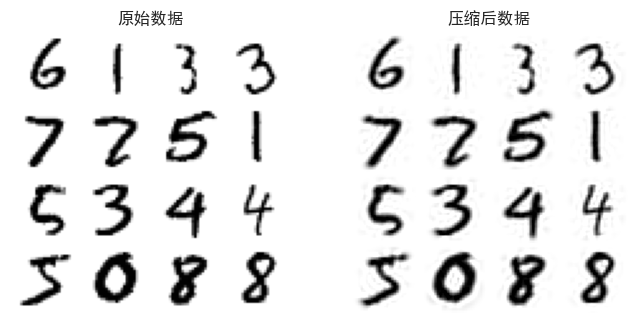

In [9]:
X_recovered = pca.inverse_transform(X_reduced) # 将数据转换回原始空间

# 下面两句是防止jupyter notebook 绘图中文显示乱码
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(8, 4))

# 使用 enumerate 函数遍历两个数据集：X_train（原始数据）和 X_recovered（压缩后数据），每次取样2000个数据点。
for idx, X in enumerate((X_train[::2000], X_recovered[::2000])):
  plt.subplot(1, 2, idx + 1)
  plt.title(["原始数据", "压缩后数据"][idx])
  # 使用嵌套的 for 循环遍历 4 行 4 列的图像位置：row 和 col。
  for row in range(4):
    for col in range(4):
      plt.imshow(X[row * 4 + col].reshape(28, 28), cmap="binary",
      vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
      plt.axis([0, 4, 0, 4])
      plt.axis("off")


若保留99%方差，至少需要331个成分


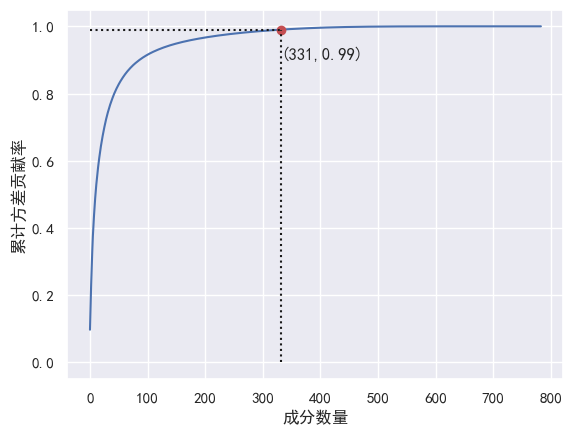

In [11]:
pca=PCA().fit(X_train_flat)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dims = np.argmax(cumsum >= 0.99) + 1 # 保留99%的方差，需要多少个成分？
print(f'若保留99%方差，至少需要{dims}个成分')

plt.plot(cumsum)
plt.xlabel('成分数量')
plt.ylabel('累计方差贡献率')
plt.plot(dims, 0.99, "ro")
plt.text(dims,0.9,'(%d,0.99)'%dims)
plt.plot([dims, dims], [0, 0.99], "k:")
plt.plot([0, dims], [0.99, 0.99], "k:")

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

# 使用MNIST数据集进行训练
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # 将每个28x28的图像展平为784维的向量
clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 180),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3, random_state=42)
rnd_search.fit(X_train_flat[:30000], y_train[:30000])  # 使用X_train_flat和y_train进行训练
print(f'搜索结果：{rnd_search.best_params_}')

搜索结果：{'randomforestclassifier__n_estimators': 323, 'pca__n_components': 45}
